In [2004]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2005]:
df = pd.read_csv("data.csv",sep=';')

In [2006]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.000,150.000,"11,9",1046.000,166.000,1056.000,113.000,1692.000,1268.000,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.000,112.000,"9,4",955.000,103.000,1174.000,92.000,1559.000,972.000,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.000,88.000,"9,0",939.000,131.000,1140.000,114.000,1555.000,1074.000,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.000,80.000,"9,2",948.000,172.000,1092.000,122.000,1584.000,1203.000,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.000,51.000,"6,5",836.000,131.000,1205.000,116.000,1490.000,1110.000,"11,2","59,6","0,7888",NaN,NaN


In [2007]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=.25, q3=.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns


In [2008]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [2009]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Class threshold for numeric but categorical variables
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat inside cat_cols.
        The sum of the 3 returned lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [2010]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool_))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (8, 8)})
        sns.heatmap(corr, cmap="RdBu",annot=True)
        plt.show()
    return drop_list

Calling the check_df function to understand the general structure of the dataset

In [2011]:
check_df(df)

##################### Shape #####################
(9471, 17)
##################### Types #####################
Date              object
Time              object
CO(GT)            object
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)          object
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                 object
RH                object
AH                object
Unnamed: 15      float64
Unnamed: 16      float64
dtype: object
##################### NA #####################
Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64
################

We can observe that the last two columns are empty. It would be more appropriate to continue by dropping these columns.

In [2012]:
df = df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1)

Finding the categorical and numeric columns with the help of the grab_col_names function

In [2013]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 9471
Variables: 15
cat_cols: 0
num_cols: 8
cat_but_car: 7
num_but_cat: 0


If we interpret the result, we can conclude that none of the columns in the dataset that seem to be categorical are categorical. They are created as an object as a type, but we do not seem to be able to evaluate them as a categorical column.

## Data Cleaning


#### 1. Fill in missing values

In [2014]:
missing_values_table(df)

               n_miss  ratio
Date              114  1.200
Time              114  1.200
CO(GT)            114  1.200
PT08.S1(CO)       114  1.200
NMHC(GT)          114  1.200
C6H6(GT)          114  1.200
PT08.S2(NMHC)     114  1.200
NOx(GT)           114  1.200
PT08.S3(NOx)      114  1.200
NO2(GT)           114  1.200
PT08.S4(NO2)      114  1.200
PT08.S5(O3)       114  1.200
T                 114  1.200
RH                114  1.200
AH                114  1.200


Looking at the results from the missing_values_table function, we see that all missing values are in the same row and the total number of rows that need to be removed is 114.

In [2015]:
df.dropna(how='all',inplace=True)

We can observe that the trailing 114 blank lines are stripped

In [2016]:
df.tail(5)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9352,04/04/2005,10.00.00,"3,1",1314.000,-200.000,"13,5",1101.000,472.000,539.000,190.000,1374.000,1729.000,"21,9","29,3","0,7568"
9353,04/04/2005,11.00.00,"2,4",1163.000,-200.000,"11,4",1027.000,353.000,604.000,179.000,1264.000,1269.000,"24,3","23,7","0,7119"
9354,04/04/2005,12.00.00,"2,4",1142.000,-200.000,"12,4",1063.000,293.000,603.000,175.000,1241.000,1092.000,"26,9","18,3","0,6406"
9355,04/04/2005,13.00.00,"2,1",1003.000,-200.000,"9,5",961.000,235.000,702.000,156.000,1041.000,770.000,"28,3","13,5","0,5139"
9356,04/04/2005,14.00.00,"2,2",1071.000,-200.000,"11,9",1047.000,265.000,654.000,168.000,1129.000,816.000,"28,5","13,1","0,5028"


But we know that not all null values in the dataset are removed. Because we have information that null values are filled with -200 value. So we find the columns with null values, and then replace with np.nan.

In [2017]:
NA_cols = [col for col in df.columns if '-200' or -200.000 in df[col].values]

In [2018]:
NA_cols

['Date',
 'Time',
 'CO(GT)',
 'PT08.S1(CO)',
 'NMHC(GT)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH']

In [2019]:
indexes = []
for col in NA_cols:
    for index,val in enumerate(df[col].tolist()):
        if val == "-200" or val == -200.000:
            df[col][index] = np.nan
            indexes.append(index)

In [2020]:
df.isnull().sum()

Date                0
Time                0
CO(GT)           1592
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)            0
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

Since most of the values of the NMHC(GT) column are null, it should be continued by dropping this column.

In [2021]:
df.drop(columns=['NMHC(GT)'],axis = 1, inplace=True)

In [2022]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH'], dtype='object')

We keep the indexes to see the rows containing np.nan in df, then we can examine the rows containing np.nan by removing the rows that were added 2 times.

In [2023]:
multiple_indexes = [index for index in indexes if indexes.count(index) > 1]
for index in multiple_indexes:
    if indexes.count(index) > 1:
        for i in range(indexes.count(index)-1):
            indexes.remove(index)

In [2024]:
df.iloc[indexes]

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
10,11/03/2004,04.00.00,NaN,1011.000,"1,3",527.000,21.000,1818.000,34.000,1197.000,445.000,"10,1","60,5","0,7465"
34,12/03/2004,04.00.00,NaN,831.000,"1,1",506.000,21.000,1893.000,32.000,1134.000,384.000,"6,1","65,9","0,6248"
58,13/03/2004,04.00.00,NaN,1147.000,"6,2",821.000,109.000,1132.000,83.000,1412.000,992.000,"7,0","71,1","0,7158"
82,14/03/2004,04.00.00,NaN,1130.000,"5,2",773.000,70.000,1130.000,82.000,1452.000,1051.000,"12,1","61,1","0,8603"
106,15/03/2004,04.00.00,NaN,1078.000,"4,0",711.000,66.000,1150.000,71.000,1468.000,1013.000,"12,3","65,4","0,9351"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8111,11/02/2005,17.00.00,"6,6",NaN,"-200,0",NaN,1227.000,NaN,326.000,NaN,NaN,NaN,NaN,NaN
8112,11/02/2005,18.00.00,"6,5",NaN,"-200,0",NaN,1061.000,NaN,284.000,NaN,NaN,NaN,NaN,NaN
8113,11/02/2005,19.00.00,"7,1",NaN,"-200,0",NaN,1075.000,NaN,289.000,NaN,NaN,NaN,NaN,NaN
8114,11/02/2005,20.00.00,"4,9",NaN,"-200,0",NaN,641.000,NaN,215.000,NaN,NaN,NaN,NaN,NaN


#### 2. Identify Outliers and Smooth Out Noisy Data

We need to get rid of null values in the dataset containing too many null values. However, we can change the outlier values with the threshold values beforehand so that the mean gives a more accurate result.

Therefore, we must first convert the object type variables to float type. However, due to a complexity in the dataset, some float values are expressed with "," while others "." written with. By taking the necessary columns (we don't need the Time Date columns here as we can't convert them to floats), we convert all commas to points, then we examine the outlier states and update the threshold values and outliers.

In [2025]:
cat_but_car.remove("Date")
cat_but_car.remove("Time")
cat_but_car

['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']

In [2026]:
for col in cat_but_car:
    df[col] = df[col].astype("string")
    for index,val in enumerate(df[col].tolist()):
        if not pd.isna(val):
                if "," in val:
                    df[col][index] = val.replace(',', '.')

In [2027]:
# Changing the object type to numeric
df[cat_but_car] = df[cat_but_car].apply(pd.to_numeric)

In [2028]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 9357
Variables: 14
cat_cols: 0
num_cols: 12
cat_but_car: 2
num_but_cat: 0


<AxesSubplot:>

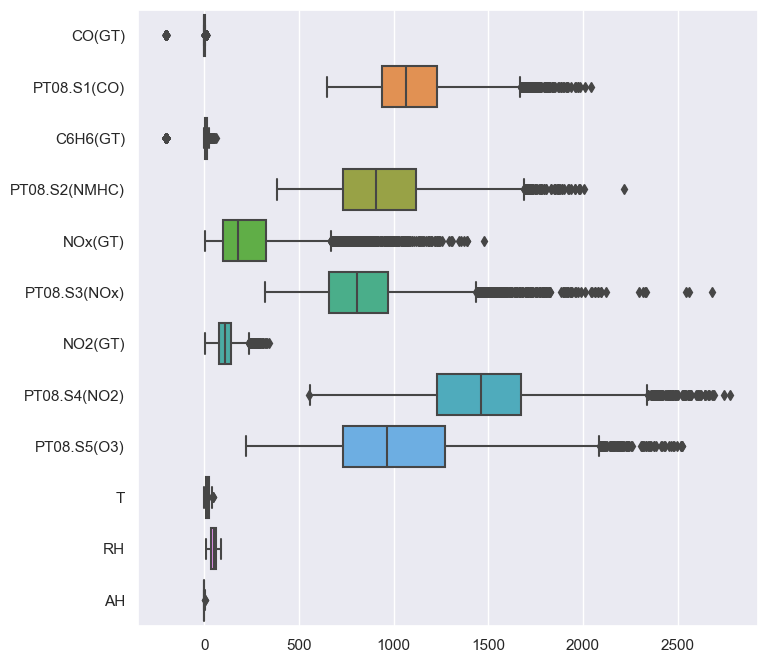

In [2029]:
sns.boxplot(data=df[num_cols], orient="h")

In [2030]:
for col in num_cols:
    print(col,check_outlier(df,col,0.1,0.90))

CO(GT) True
PT08.S1(CO) False
C6H6(GT) True
PT08.S2(NMHC) False
NOx(GT) True
PT08.S3(NOx) True
NO2(GT) False
PT08.S4(NO2) False
PT08.S5(O3) False
T False
RH False
AH False


In [2031]:
for col in num_cols:
    replace_with_thresholds(df,col,0.1,0.90)
for col in num_cols:
    print(col,check_outlier(df,col,0.1,0.90))

CO(GT) False
PT08.S1(CO) False
C6H6(GT) False
PT08.S2(NMHC) False
NOx(GT) False
PT08.S3(NOx) False
NO2(GT) False
PT08.S4(NO2) False
PT08.S5(O3) False
T False
RH False
AH False


After that, we need to get rid of the nulls in the dataset that contains too many nulls. Therefore, we fill in the blank values in the remaining columns with the average value of the column.

In [2032]:
df = df.fillna(df.mean())

In [2033]:
df

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.600,1360.000,11.900,1046.000,166.000,1056.000,113.000,1692.000,1268.000,13.600,48.900,0.758
1,10/03/2004,19.00.00,2.000,1292.000,9.400,955.000,103.000,1174.000,92.000,1559.000,972.000,13.300,47.700,0.726
2,10/03/2004,20.00.00,2.200,1402.000,9.000,939.000,131.000,1140.000,114.000,1555.000,1074.000,11.900,54.000,0.750
3,10/03/2004,21.00.00,2.200,1376.000,9.200,948.000,172.000,1092.000,122.000,1584.000,1203.000,11.000,60.000,0.787
4,10/03/2004,22.00.00,1.600,1272.000,6.500,836.000,131.000,1205.000,116.000,1490.000,1110.000,11.200,59.600,0.789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.100,1314.000,13.500,1101.000,472.000,539.000,190.000,1374.000,1729.000,21.900,29.300,0.757
9353,04/04/2005,11.00.00,2.400,1163.000,11.400,1027.000,353.000,604.000,179.000,1264.000,1269.000,24.300,23.700,0.712
9354,04/04/2005,12.00.00,2.400,1142.000,12.400,1063.000,293.000,603.000,175.000,1241.000,1092.000,26.900,18.300,0.641
9355,04/04/2005,13.00.00,2.100,1003.000,9.500,961.000,235.000,702.000,156.000,1041.000,770.000,28.300,13.500,0.514


#### 3. Correct Inconsistent Data

However, when we examine it carefully, we realize that the dataset contains inconsistent data. Such as CO Concentration and Benzene concentration having values less than 0. Therefore, we can fill these negative values with mean values.

In [2034]:
for index,val in enumerate(df["CO(GT)"]):
    if val < 0:
        df["CO(GT)"][index] = df["CO(GT)"].mean()

In [2035]:
for index,val in enumerate(df["C6H6(GT)"]):
    if val < 0:
        df["C6H6(GT)"][index] = df["C6H6(GT)"].mean()

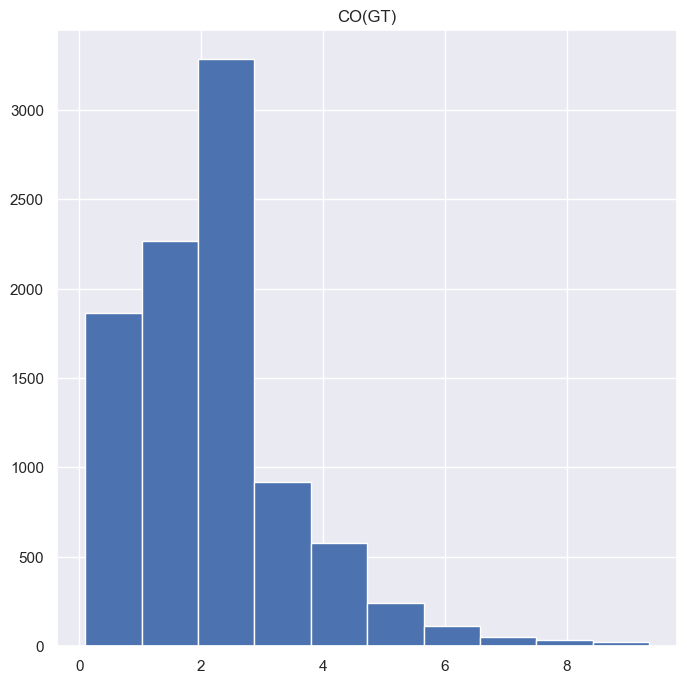

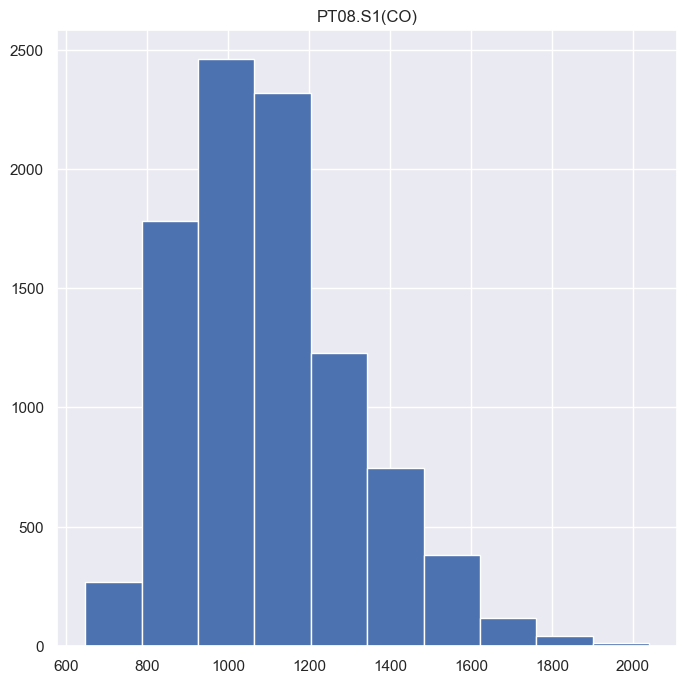

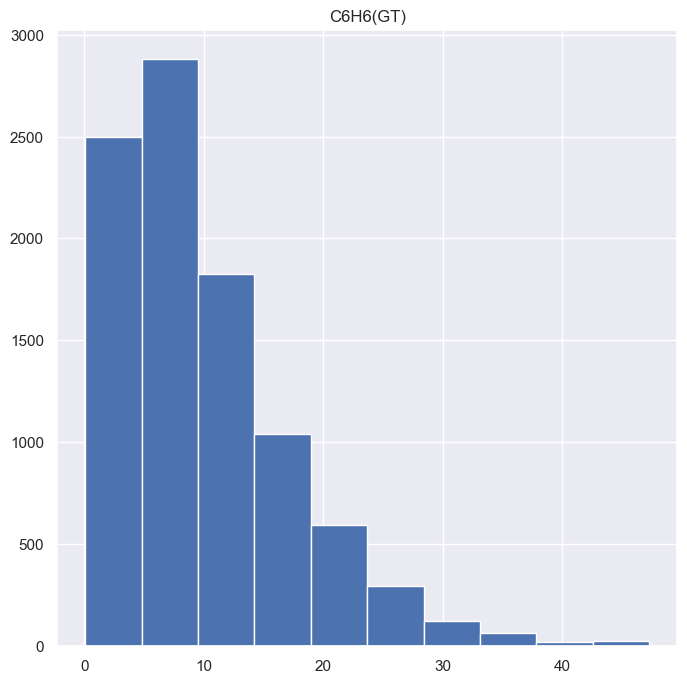

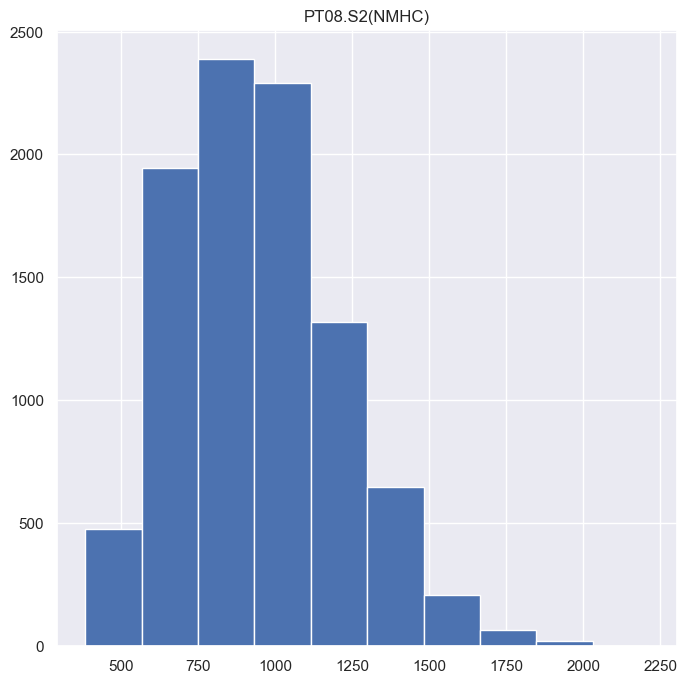

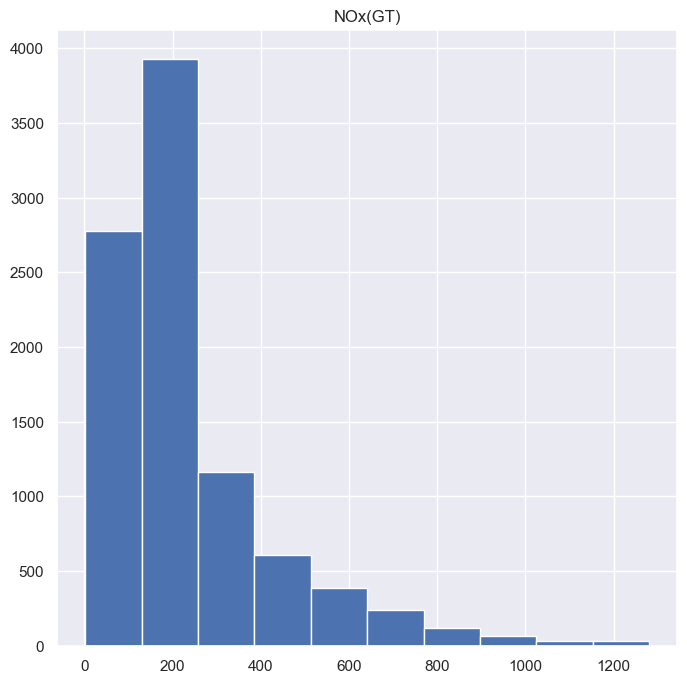

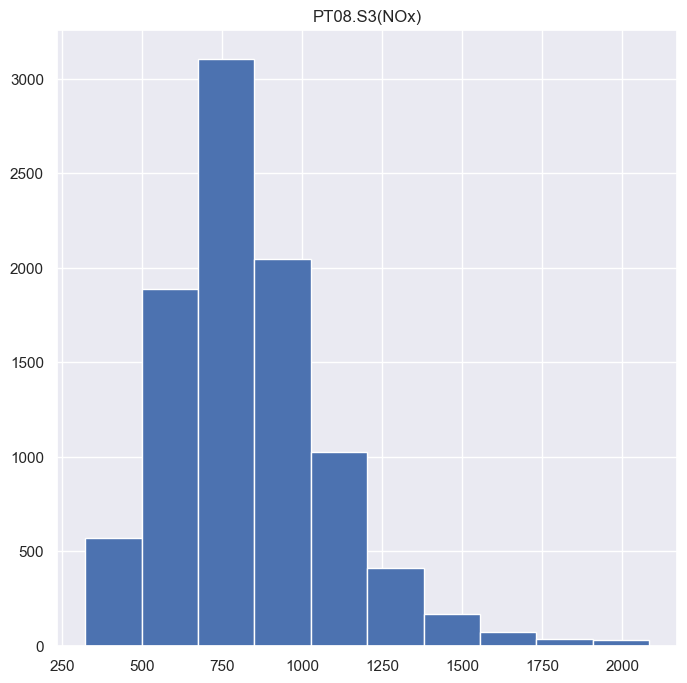

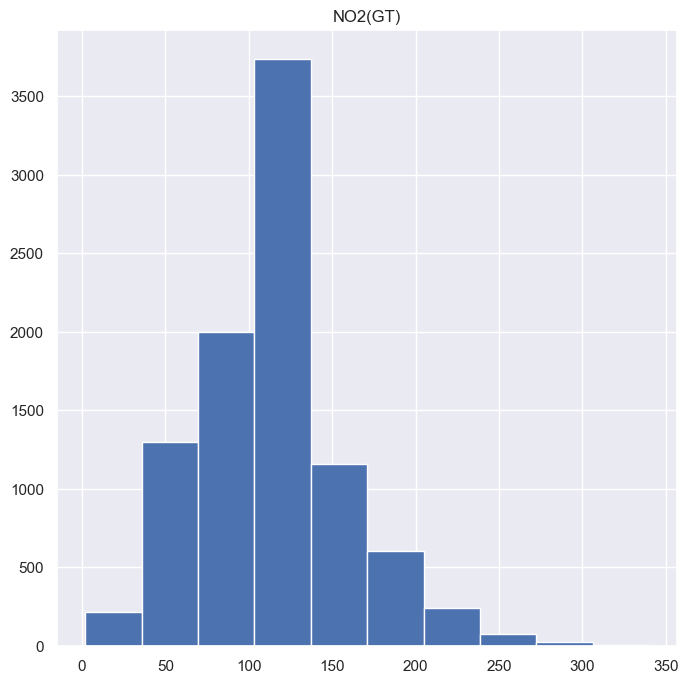

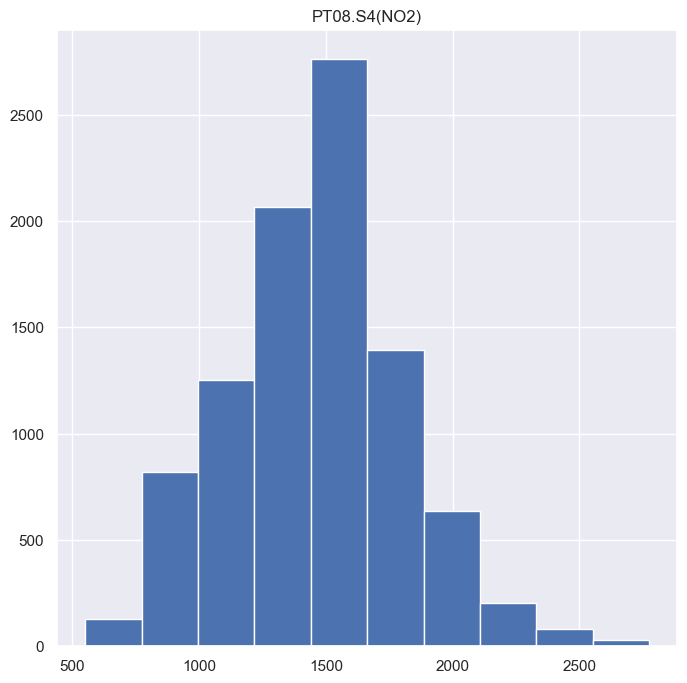

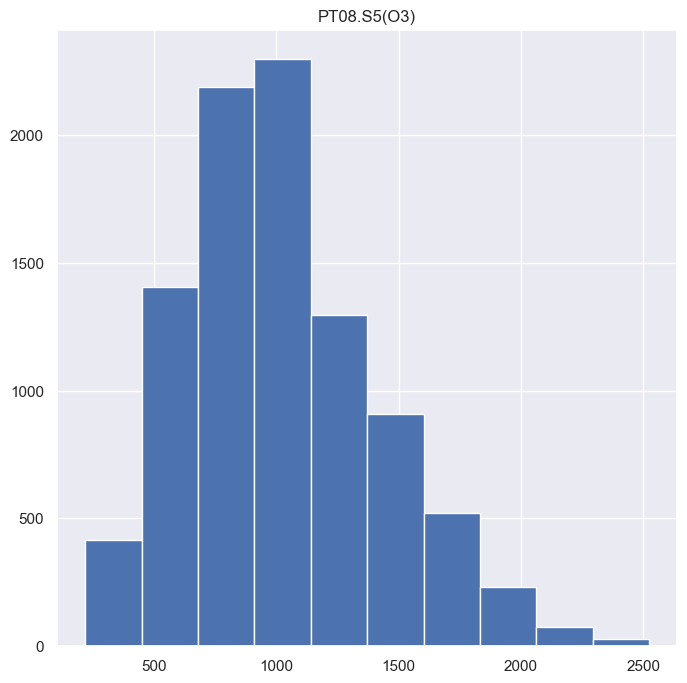

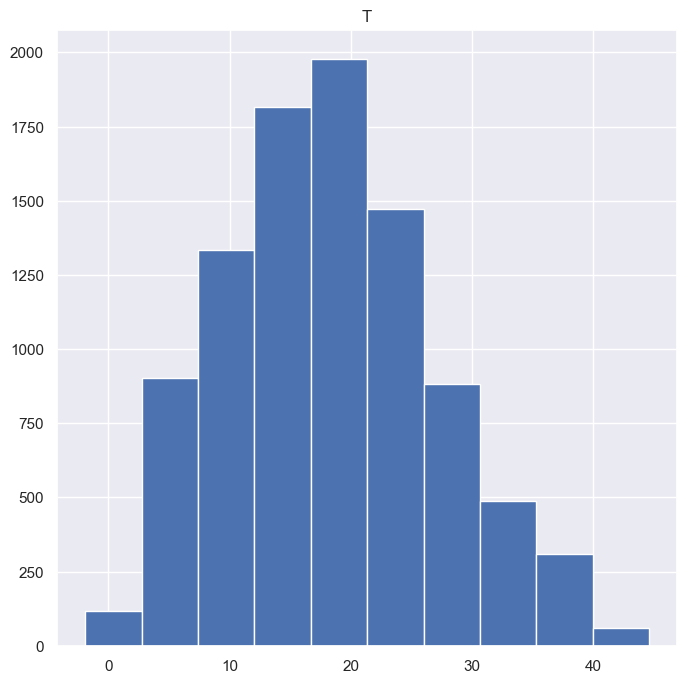

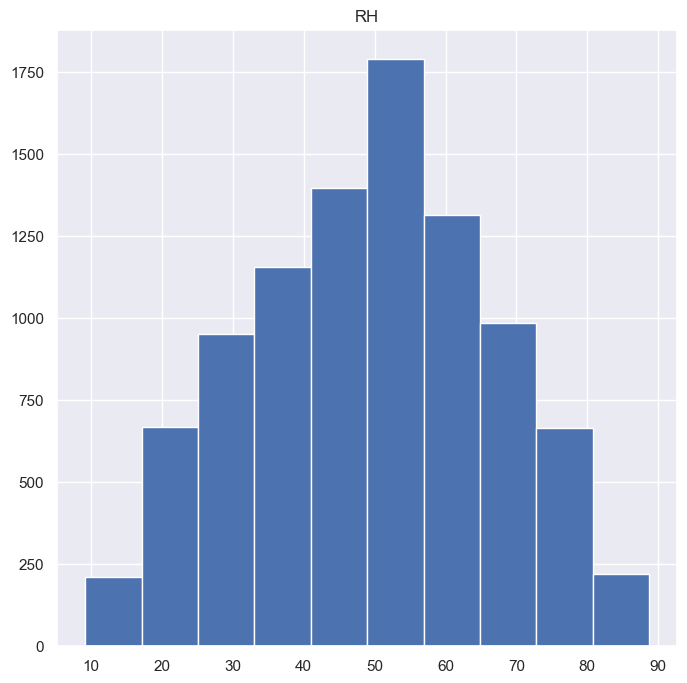

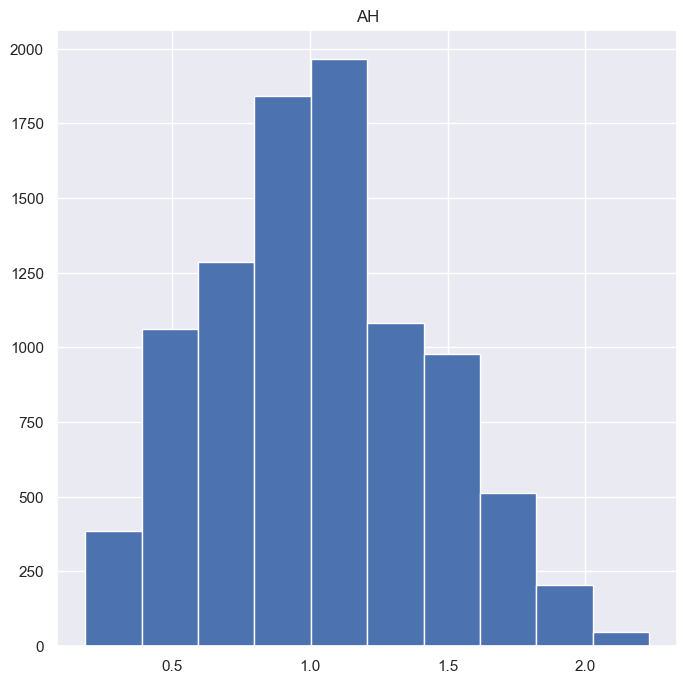

In [2036]:
for col in num_cols:
    df.hist(column=col);

### Data transformation

#### 1. Normalization

The Min-max approach, often called normalization, subtracts the minimum value of the feature and divides it by the range, rescaling the feature to the fixed and fast range of [0,1]. We can implement min-max scaling in Pandas using the min() and .max() methods.

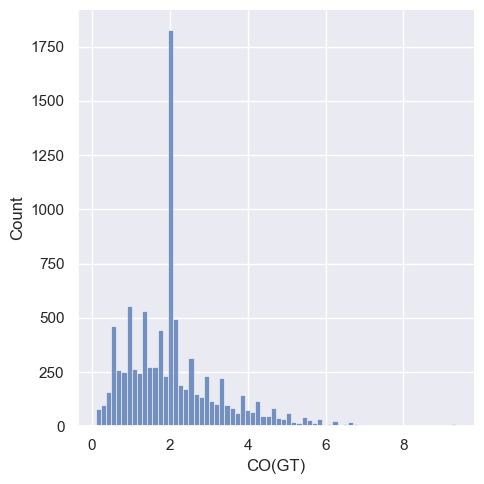

In [2037]:
sns.displot(df["CO(GT)"])

In [2038]:
for column in num_cols:
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

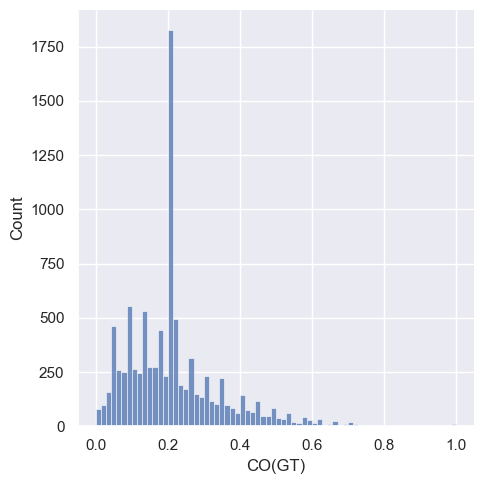

In [2039]:
sns.displot(df["CO(GT)"])

In [2040]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,0.270,0.512,0.250,0.362,0.128,0.417,0.328,0.513,0.455,0.333,0.499,0.280
1,10/03/2004,19.00.00,0.205,0.463,0.197,0.312,0.079,0.484,0.266,0.453,0.326,0.327,0.484,0.264
2,10/03/2004,20.00.00,0.227,0.542,0.189,0.304,0.101,0.464,0.331,0.451,0.371,0.297,0.564,0.276
3,10/03/2004,21.00.00,0.227,0.523,0.193,0.309,0.133,0.437,0.355,0.464,0.427,0.277,0.639,0.294
4,10/03/2004,22.00.00,0.162,0.449,0.136,0.247,0.101,0.501,0.337,0.422,0.386,0.282,0.634,0.295


#### 2. Aggregation

In [2041]:
df[num_cols].aggregate(['sum', 'mean'])

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
sum,2061.269,3041.752,1974.828,2842.123,1791.665,2726.158,3075.387,3808.705,3259.529,4068.349,4711.950,3844.817
mean,0.220,0.325,0.211,0.304,0.191,0.291,0.329,0.407,0.348,0.435,0.504,0.411


Assuming the RH column as output, we observe the relationship with other input features like this:

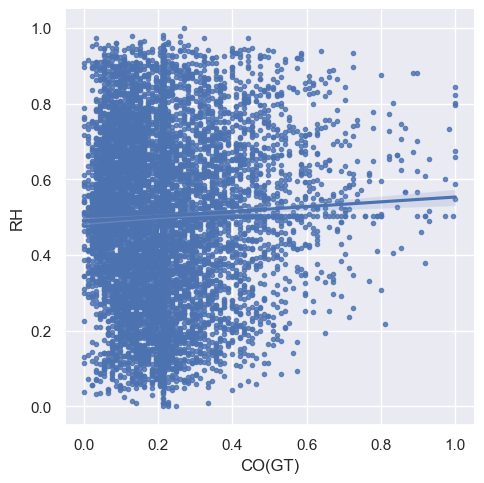

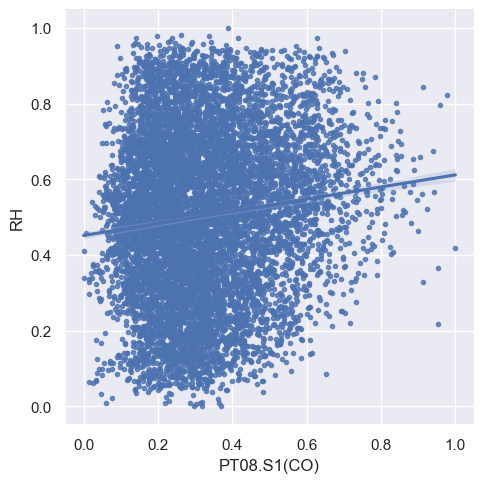

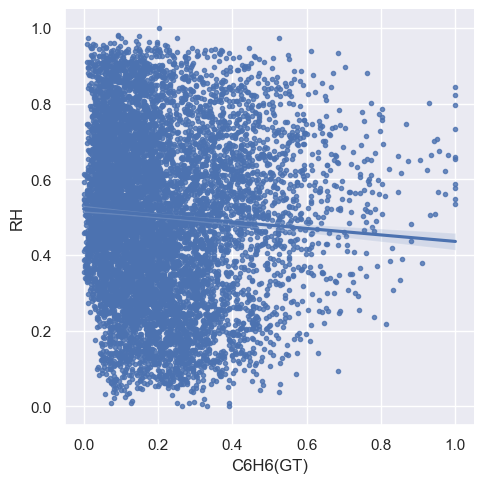

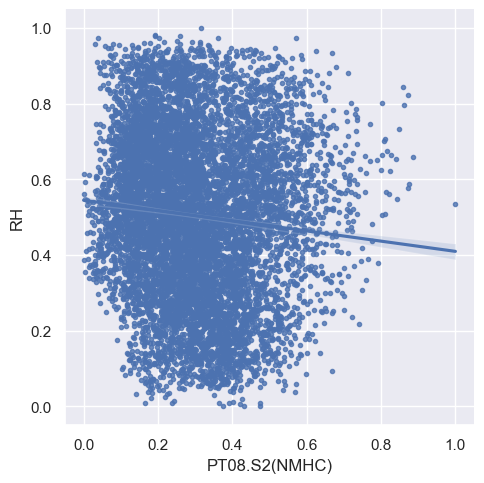

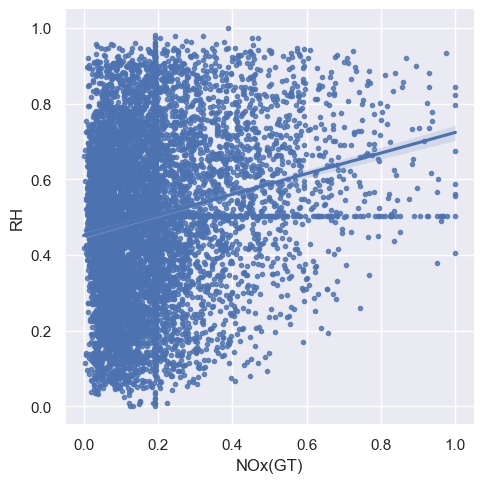

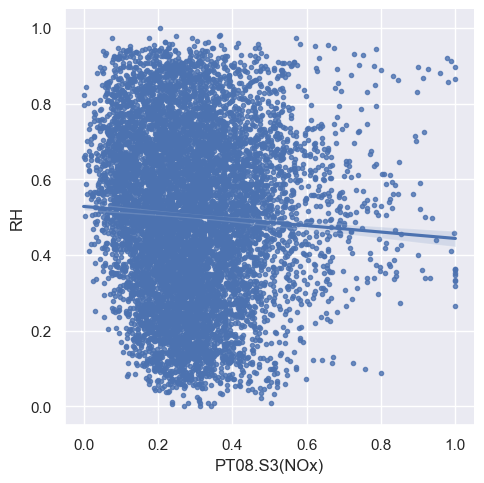

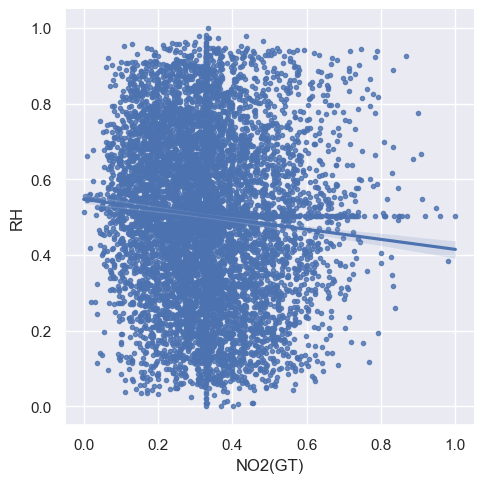

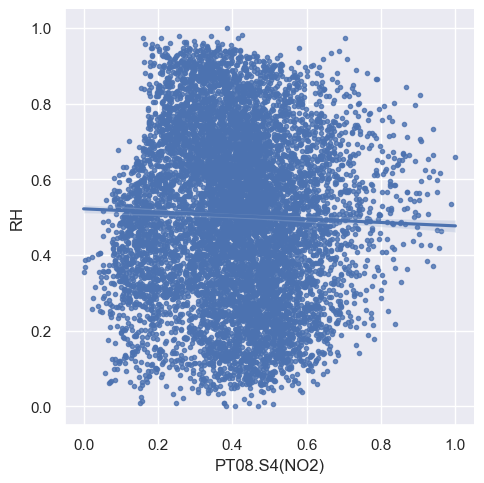

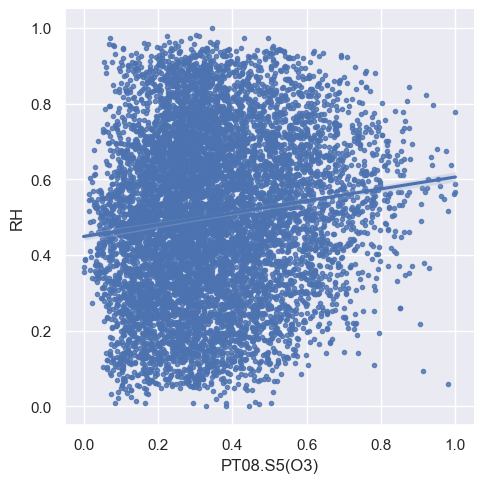

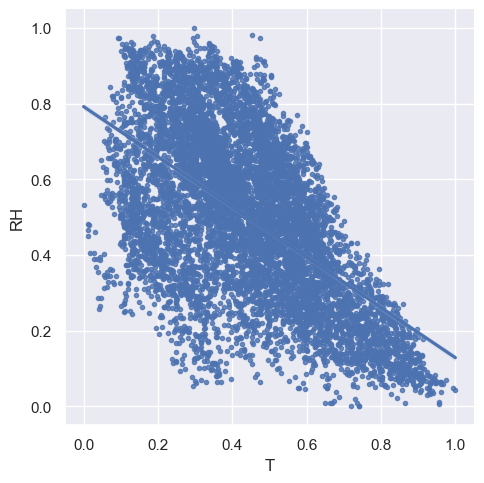

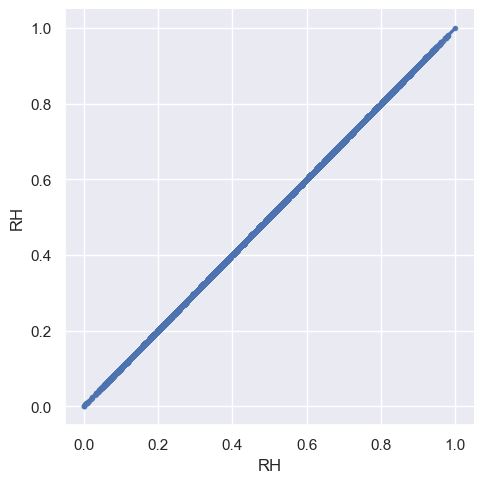

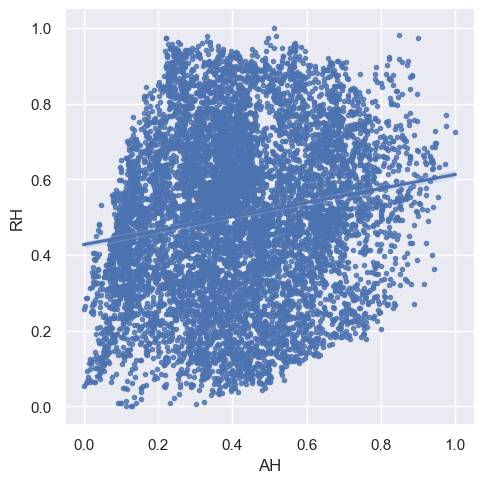

In [2042]:
col_=df.columns.tolist()[2:]
for i in df.columns.tolist()[2:]:
    sns.lmplot(x=i,y='RH',data=df,markers='.')

In [2043]:
agg_func_math = {'RH':['sum', 'mean', 'median', 'min', 'max']}
for col in num_cols:
    if not col == "RH":
        print(df.groupby(col).agg(agg_func_math).round(2))

            RH                         
           sum  mean median   min   max
CO(GT)                                 
0.000   16.610 0.500  0.510 0.040 0.910
0.011   21.900 0.490  0.470 0.070 0.910
0.022   48.560 0.500  0.500 0.060 0.950
0.032   84.370 0.530  0.530 0.030 0.970
0.043  116.150 0.540  0.540 0.030 0.950
...        ...   ...    ...   ...   ...
0.930    1.660 0.550  0.520 0.490 0.650
0.973    1.100 0.550  0.550 0.500 0.600
0.984    0.730 0.730  0.730 0.730 0.730
0.995    0.500 0.500  0.500 0.500 0.500
1.000    5.730 0.720  0.740 0.550 0.840

[182 rows x 5 columns]
               RH                         
              sum  mean median   min   max
PT08.S1(CO)                               
0.000       0.340 0.340  0.340 0.340 0.340
0.001       0.410 0.410  0.410 0.410 0.410
0.006       0.460 0.460  0.460 0.460 0.460
0.014       0.700 0.230  0.300 0.060 0.340
0.016       0.330 0.330  0.330 0.330 0.330
...           ...   ...    ...   ...   ...
0.952       0.220 0.220  0.22

Changing the column names for clear understanding

In [2044]:
df.rename(columns={'CO(GT)': 'CO Concentration',
                   'PT08.S1(CO)':'Tin Oxide Sensor Response(CO)',
                   'C6H6(GT)':'Benzene concentration',
                   'PT08.S2(NMHC)':'Titania Sensor Response(NMHC)',
                   'NOx(GT)':'NOx Concentration',
                   'PT08.S3(NOx)':'Tungsten Oxide Sensor Response(N0x)',
                   'NO2(GT)':'NO2 Concentration',
                   'PT08.S4(NO2)':'Tungsten Oxide Sensor Response(NO2)',
                   'PT08.S5(O3)':'Indium Oxide Sensor Response(O3)',
                   'T':'Temperature',
                   'RH':'Relative Humidity',
                   'AH':'Absolute Humidity'
                   }, inplace=True)

In [2045]:
df.head()

,Date,Time,CO Concentration,Tin Oxide Sensor Response(CO),Benzene concentration,Titania Sensor Response(NMHC),NOx Concentration,Tungsten Oxide Sensor Response(N0x),NO2 Concentration,Tungsten Oxide Sensor Response(NO2),Indium Oxide Sensor Response(O3),Temperature,Relative Humidity,Absolute Humidity
0,10/03/2004,18.00.00,0.270,0.512,0.250,0.362,0.128,0.417,0.328,0.513,0.455,0.333,0.499,0.280
1,10/03/2004,19.00.00,0.205,0.463,0.197,0.312,0.079,0.484,0.266,0.453,0.326,0.327,0.484,0.264
2,10/03/2004,20.00.00,0.227,0.542,0.189,0.304,0.101,0.464,0.331,0.451,0.371,0.297,0.564,0.276
3,10/03/2004,21.00.00,0.227,0.523,0.193,0.309,0.133,0.437,0.355,0.464,0.427,0.277,0.639,0.294
4,10/03/2004,22.00.00,0.162,0.449,0.136,0.247,0.101,0.501,0.337,0.422,0.386,0.282,0.634,0.295


#### Attribute Construction

In [2046]:
index = 0
for date in df["Date"]:
    df["Date"][index]= date.replace("/", "-")
    index+=1
df['Date']=pd.to_datetime(df.Date, format='%d-%m-%Y')
df['Month']= df['Date'].dt.month
df.head()

,Date,Time,CO Concentration,Tin Oxide Sensor Response(CO),Benzene concentration,Titania Sensor Response(NMHC),NOx Concentration,Tungsten Oxide Sensor Response(N0x),NO2 Concentration,Tungsten Oxide Sensor Response(NO2),Indium Oxide Sensor Response(O3),Temperature,Relative Humidity,Absolute Humidity,Month
0,2004-03-10,18.00.00,0.270,0.512,0.250,0.362,0.128,0.417,0.328,0.513,0.455,0.333,0.499,0.280,3
1,2004-03-10,19.00.00,0.205,0.463,0.197,0.312,0.079,0.484,0.266,0.453,0.326,0.327,0.484,0.264,3
2,2004-03-10,20.00.00,0.227,0.542,0.189,0.304,0.101,0.464,0.331,0.451,0.371,0.297,0.564,0.276,3
3,2004-03-10,21.00.00,0.227,0.523,0.193,0.309,0.133,0.437,0.355,0.464,0.427,0.277,0.639,0.294,3
4,2004-03-10,22.00.00,0.162,0.449,0.136,0.247,0.101,0.501,0.337,0.422,0.386,0.282,0.634,0.295,3


In [2047]:
index = 0
for date in df["Time"]:
    df["Time"][index]= date.replace(".", ":")
    index+=1
df['Hour']=df['Time'].apply(lambda x: int(x.split(':')[0]))

In [2048]:
df.drop(columns = ["Time"],inplace = True)

In [2049]:
df.head()

,Date,CO Concentration,Tin Oxide Sensor Response(CO),Benzene concentration,Titania Sensor Response(NMHC),NOx Concentration,Tungsten Oxide Sensor Response(N0x),NO2 Concentration,Tungsten Oxide Sensor Response(NO2),Indium Oxide Sensor Response(O3),Temperature,Relative Humidity,Absolute Humidity,Month,Hour
0,2004-03-10,0.270,0.512,0.250,0.362,0.128,0.417,0.328,0.513,0.455,0.333,0.499,0.280,3,18
1,2004-03-10,0.205,0.463,0.197,0.312,0.079,0.484,0.266,0.453,0.326,0.327,0.484,0.264,3,19
2,2004-03-10,0.227,0.542,0.189,0.304,0.101,0.464,0.331,0.451,0.371,0.297,0.564,0.276,3,20
3,2004-03-10,0.227,0.523,0.193,0.309,0.133,0.437,0.355,0.464,0.427,0.277,0.639,0.294,3,21
4,2004-03-10,0.162,0.449,0.136,0.247,0.101,0.501,0.337,0.422,0.386,0.282,0.634,0.295,3,22


### Data Reduction

Now we can begin to examine the correlation between columns. According to the results from this correlation matrix, we can exclude columns that explain each other from our data.

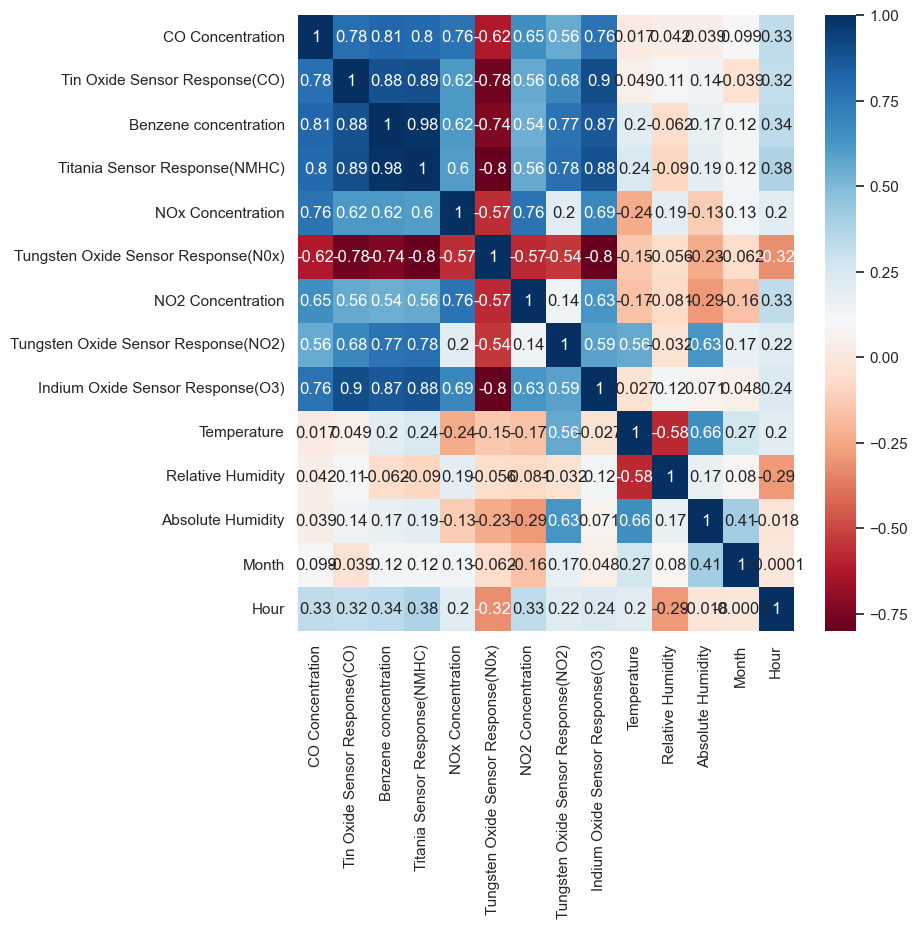

['Benzene concentration',
 'Titania Sensor Response(NMHC)',
 'Tungsten Oxide Sensor Response(N0x)',
 'Indium Oxide Sensor Response(O3)']

In [2050]:
high_correlated_cols(df,True,0.8)

As we observed from the correlation matrix, the 'Titania Sensor Response(NMHC)','CO Concentration','Tin Oxide Sensor Response(CO)','Indium Oxide Sensor Response(O3)' columns can be explained by the Benzene Concentration column by over eighty percent. We can also remove these columns from our data frame, as they do not give us any different information about the data.

In [2051]:
df.drop(columns = ['Titania Sensor Response(NMHC)','CO Concentration','Tin Oxide Sensor Response(CO)','Indium Oxide Sensor Response(O3)'],axis = 1, inplace = True)

In [2052]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 9357
Variables: 11
cat_cols: 0
num_cols: 11
cat_but_car: 0
num_but_cat: 0


In [2053]:
check_df(df)

##################### Shape #####################
(9357, 11)
##################### Types #####################
Date                                   datetime64[ns]
Benzene concentration                         float64
NOx Concentration                             float64
Tungsten Oxide Sensor Response(N0x)           float64
NO2 Concentration                             float64
Tungsten Oxide Sensor Response(NO2)           float64
Temperature                                   float64
Relative Humidity                             float64
Absolute Humidity                             float64
Month                                           int64
Hour                                            int64
dtype: object
##################### NA #####################
Date                                   0
Benzene concentration                  0
NOx Concentration                      0
Tungsten Oxide Sensor Response(N0x)    0
NO2 Concentration                      0
Tungsten Oxide Sensor Respons

### CONCLUSION

The dataset, which has gone through many stages, is now ready for use in a machine learning model, and the preprocessing processes are completed. However, these processes can be increased and diversified according to the results to be obtained from the different models that have been tried.

While doing all these processes, I observed once again that perhaps the most important step in developing a machine learning model is the steps I performed during this assignment, namely the preprocessing steps. While the data given at the beginning contains many data that may cause incorrect learning of the model, I tried to fill and change these errors in the most appropriate way to debug, especially in the data cleaning step. Then, in the data transformation step, I normalized the numerical columns and tried to ensure that no features would bias the model. In another important step, Data Reduction, I tried to remove unnecessary columns from the data and make the data clearer for the model to learn. At this stage, if we had repeated data in our dataset, we should have removed this data and prevented it from creating bias again. In this way, we could create a suitable sampling example, but at this stage, I thought it would be enough to examine the Correalatin matrix and remove the columns that explain each other too much. After that, I changed the column names in accordance with the explanations so that the person who will process the data that is ready for use can better understand it.

As a result, I worked diligently to perform every step that allowed me to better understand the data.